In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, Concatenate,ReLU
from tensorflow.keras.activations import sigmoid
import numpy as np
from keras.preprocessing import image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from keras.utils.vis_utils import plot_model
import random
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.io import imread,imshow,imread_collection,concatenate_images
from skimage.transform import resize
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# U-Net
The U-Net architecture is a popular convolutional neural network (CNN) architecture which is applied for various image processing tasks. 

It's U-shaped network design, the high level architecture consisting of 
*     a) Contracting path(encoder) for feature extraction,
*     b) Bottleneck Layer for Feature abstraction and compression and 
*     c) Expansive path(decoder) for precise localization

By using this architecture we have developed the model.

**Contracting Path**

The contracting path (encoder) downsizes feature maps and extracts high-level features using convolutional layers and max-pooling, enabling the network to capture essential information while reducing spatial dimensions. It serves as the feature extractor in the U-Net architectur

In [9]:
def contracting_path(input_layer, filters, padding, kernel_size=3):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding=padding)(input_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding=padding)(conv)
    pool = MaxPooling2D(pool_size=2, strides=2)(conv)
    return conv, pool

**Bottleneck path**

    It is the core of the U-Net. It has a large number of feature channels and compact spatial dimensions. It helps to maintain important data for accurate segmentation.

In [11]:
def bottleneck_path(input_layer, filters, padding, kernel_size=3, strides=1):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, activation='relu')(input_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, activation='relu')(conv)
    return conv

**Expansive Path**

It utilizes skip connections from the contracting path for better segmentation accuracy and employs transpose convolutions to upsample feature maps and recover spatial features. A high-resolution segmentation map is reconstructed.


In [13]:
# We are using crop_to_match in the expansive path to make sure that the feature maps (tensors) from the contracting path (downsampling) and expansive path (upsampling) have the same spatial dimensions prior to concatenation.
def crop_to_match(source_tensor, target_tensor):
    source_shape = source_tensor.get_shape().as_list()
    target_shape = target_tensor.get_shape().as_list()
    crop_h = (source_shape[1] - target_shape[1]) // 2
    crop_w = (source_shape[2] - target_shape[2]) // 2
    cropped = source_tensor[:, crop_h:crop_h + target_shape[1], crop_w:crop_w + target_shape[2], :]
    return cropped

In [14]:
def expansive_path(input_layer, skip_conn_layer, filters, padding, kernel_size=3, strides=1):
    transConv = Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=2, padding=padding)(input_layer)

    if padding == "valid":
        cropped = crop_to_match(transConv, skip_conn_layer)
        concat = Concatenate()([transConv, cropped])
    else:
        concat = Concatenate()([transConv, skip_conn_layer])

    up_conv = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')(concat)
    up_conv = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')(up_conv)
    return up_conv



# Data Preparation

In [3]:
# Copy the data to the working folder
src_dir = '/kaggle/input/u-net-ds/train/'
dest_dir = '/kaggle/working/data'

# Define the destination 'data' directory
data_dir = os.path.join(dest_dir, 'data')

# Copy the data from the input directory to the working directory
shutil.copytree(src_dir, data_dir)

print(f"Data has been copied from '{src_dir}' to '{data_dir}'")

Data has been copied from '/kaggle/input/u-net-ds/train/' to '/kaggle/working/data/data'


In [4]:
# split and move data to subfolders
def move_subfolders(src_dir, dest_train_dir, train_subfolders):
    for folder in train_subfolders:
        src = os.path.join(src_dir, folder)
        dest = os.path.join(dest_train_dir, folder)
        shutil.move(src, dest)

# Define paths
data_dir = '/kaggle/working/data/data'

# List subfolders with images and masks
subfolders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Split the data into train, test, and validation sets
train_subfolders, test_subfolders = train_test_split(subfolders, test_size=0.1, random_state=42)

move_subfolders(data_dir,  '/kaggle/working/train', train_subfolders)
move_subfolders(data_dir, '/kaggle/working/test', test_subfolders)


# Split the data to train and test

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
from skimage.transform import resize
import os

def load_data(train_dir, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL):
    ids = next(os.walk(train_dir))[1]
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
    Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    for n, _id in tqdm(enumerate(ids)):
        path = os.path.join(train_dir, _id)
        img = imread(os.path.join(path, "images", f"{_id}.png"))[:, :, :IMG_CHANNEL]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
        X[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(os.path.join(path, "masks")))[2]:
            mask_ = imread(os.path.join(path, "masks", mask_file))
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y[n] = mask

    return X, Y

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNEL = 3

X_train, y_train = load_data('/kaggle/working/train/', IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)

X_test, y_test = load_data('/kaggle/working/test/', IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)

/tmp/ipykernel_32/1448976645.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
0it [00:00, ?it/s]/tmp/ipykernel_32/1448976645.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
603it [03:39,  2.75it/s]
67it [00:32,  2.04i

**Data Augmentation**

In [6]:
seed = None
BATCH_SIZE = 32

# Define data augmentation settings
data_augmentation = image.ImageDataGenerator(
    shear_range=0.5,
    rotation_range=50,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="reflect"
)

# Split the data into training and validation sets
split_index = int(X_train.shape[0] * 0.9)
X_train_split = X_train[:split_index]
y_train_split = y_train[:split_index]
X_val_split = X_train[split_index:]
y_val_split = y_train[split_index:]



In [8]:
# Fit the data generator to the training data
data_augmentation.fit(X_train_split, augment=True, seed=42)

# Create data generators for training data
x_train = data_augmentation.flow(X_train_split, batch_size=BATCH_SIZE, shuffle=True, seed=42)
y_train = data_augmentation.flow(y_train_split, batch_size=BATCH_SIZE, shuffle=True, seed=42)

# Create data generators for validation data
x_val = data_augmentation.flow(X_val_split, batch_size=BATCH_SIZE, shuffle=True, seed=42)
y_val = data_augmentation.flow(y_val_split, batch_size=BATCH_SIZE, shuffle=True, seed=42)

train_generator = zip(x_train,y_train)
val_generator = zip(x_val,y_val)


**Define U-Net Model**

In [21]:
image_size = (256, 256, 3)
filters = [16, 32, 64, 128, 256]
padding = 'same'


UnetInput = Input(image_size)
conv1, pool1 = contracting_path(input_layer=UnetInput, filters=filters[0], padding=padding)
conv2, pool2 = contracting_path(input_layer=pool1, filters=filters[1], padding=padding)
conv3, pool3 = contracting_path(input_layer=pool2, filters=filters[2], padding=padding)
conv4, pool4 = contracting_path(input_layer=pool3, filters=filters[3], padding=padding)
bottleNeck = bottleneck_path(pool4, filters=filters[4], padding=padding)
upConv1 = expansive_path(bottleNeck, conv4, filters=filters[3], padding=padding)
upConv2 = expansive_path(upConv1, conv3, filters=filters[2], padding=padding)
upConv3 = expansive_path(upConv2, conv2, filters=filters[1], padding=padding)
upConv4 = expansive_path(upConv3, conv1, filters=filters[0], padding=padding)
UnetOutput = Conv2D(1, (1, 1), padding=padding, activation=sigmoid)(upConv4)
model = Model(UnetInput, UnetOutput, name="UNet")


In [22]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_19[0][0]']              
                                )                                                              

### Model Training

In [23]:
# Define the ModelCheckpoint and EarlyStopping callbacks
checkp = ModelCheckpoint('./unet_model.h5', monitor='accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_steps=10, steps_per_epoch=50,epochs=20,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[checkp, early_stopping]
)


Epoch 1/20
50/50 [==============================] - 52s 879ms/step - loss: 0.7153 - acc: 0.8101 - val_loss: 0.4360 - val_acc: 0.8551
Epoch 2/20
50/50 [==============================] - 41s 832ms/step - loss: 0.2458 - acc: 0.8778 - val_loss: 0.2563 - val_acc: 0.8912
Epoch 3/20
50/50 [==============================] - 41s 833ms/step - loss: 0.2062 - acc: 0.8984 - val_loss: 0.2614 - val_acc: 0.9058
Epoch 4/20
50/50 [==============================] - 41s 831ms/step - loss: 0.2057 - acc: 0.9021 - val_loss: 0.2473 - val_acc: 0.9004
Epoch 5/20
50/50 [==============================] - 42s 847ms/step - loss: 0.1604 - acc: 0.9226 - val_loss: 0.1902 - val_acc: 0.9253
Epoch 6/20
50/50 [==============================] - 41s 829ms/step - loss: 0.1414 - acc: 0.9317 - val_loss: 0.1842 - val_acc: 0.9309
Epoch 7/20
50/50 [==============================] - 41s 832ms/step - loss: 0.1297 - acc: 0.9347 - val_loss: 0.2118 - val_acc: 0.9227
Epoch 8/20
50/50 [==============================] - 41s 830ms/step - 

**Plot the Graphs for loss and Accuray**

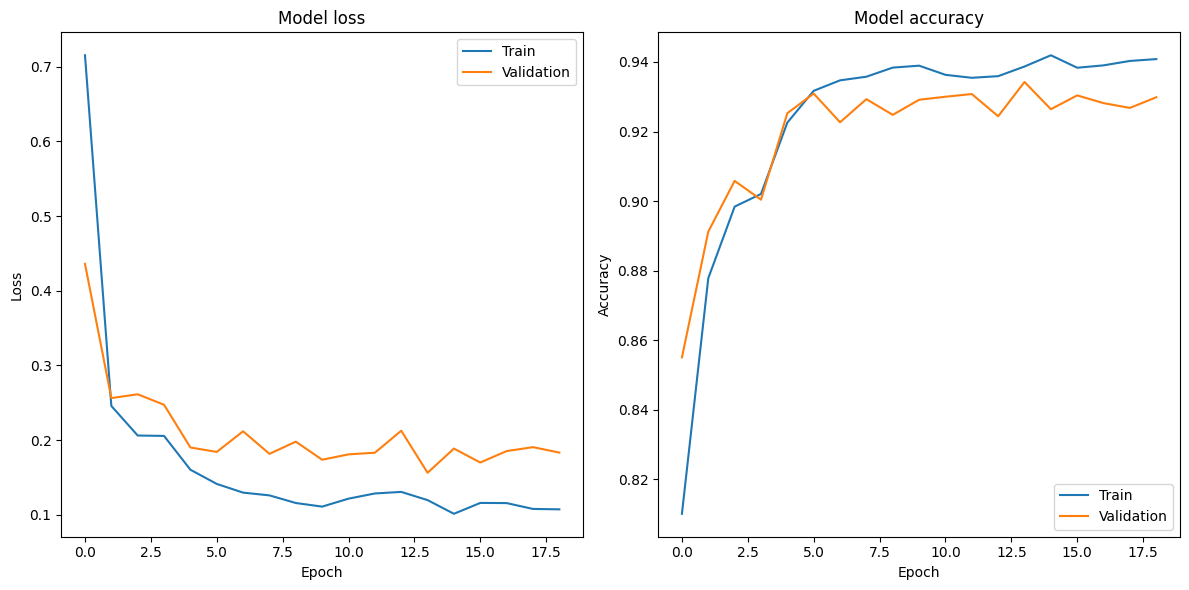

In [25]:
# Val and train Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Val and Train Acc 
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()


### Model Testing and Prediction Visualizations

In [26]:
# Evulate the model on test data
results = model.evaluate(X_test, y_test, verbose=1)

print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

3/3 [==============================] - 1s 395ms/step - loss: 0.0767 - acc: 0.9700
Test Loss: 0.07672237604856491
Test Accuracy: 0.970023512840271


1/1 [==============================] - 0s 21ms/step


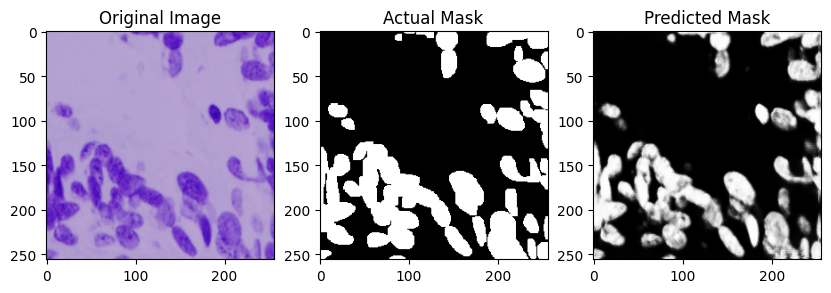

1/1 [==============================] - 0s 19ms/step


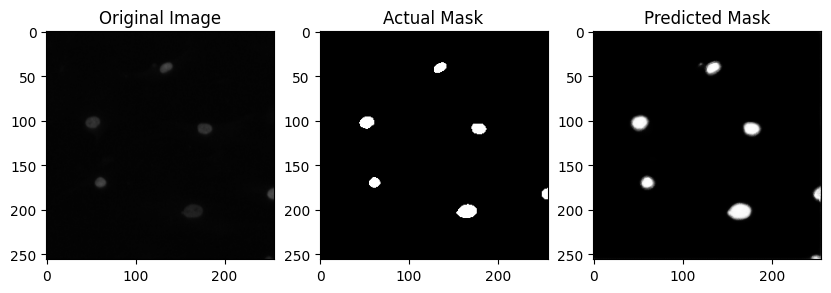

1/1 [==============================] - 0s 25ms/step


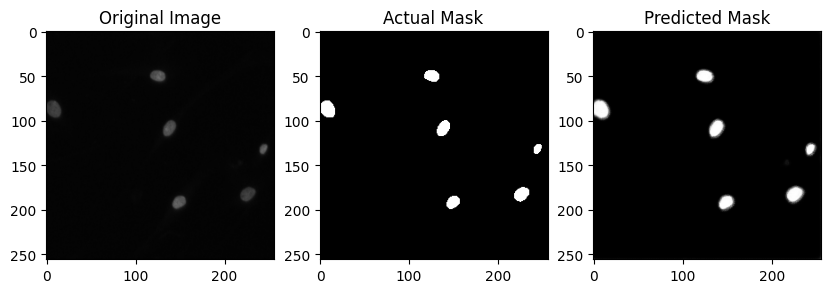

1/1 [==============================] - 0s 21ms/step


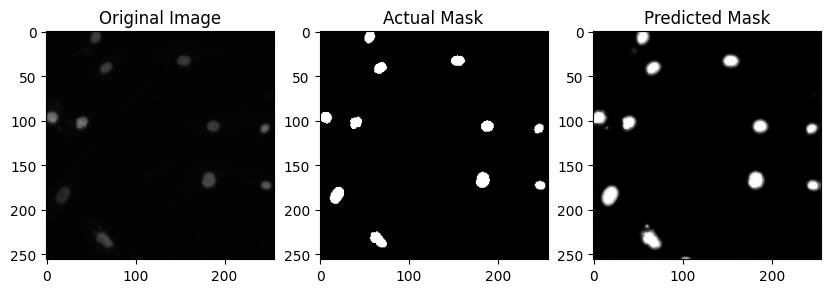

1/1 [==============================] - 0s 20ms/step


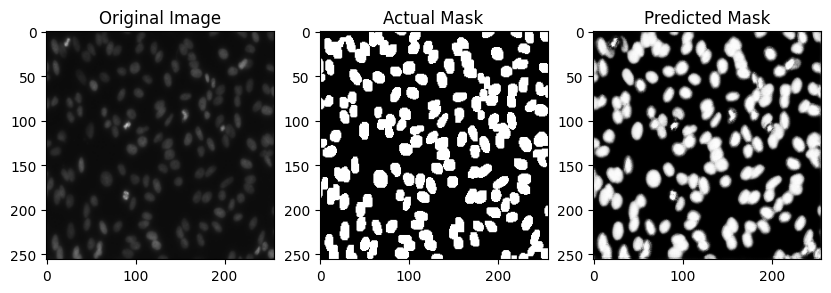

In [28]:

# Generate visualization for the test images
sample_indices = random.sample(range(len(X_test)), 5)

# Loop through the sample indices
for i in sample_indices:
    
    image = X_test[i]
    mask = y_test[i]

    # Predicting the mask by using teh model
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

    # Plot the original image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")

    # Plot the actual mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Actual Mask")

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()
